# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# Load Dataset

In [2]:
data=pd.read_csv('yelp.csv')
data.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


Looking at the first few rows of the data, it raises questions as to what is the target here? What are the important features to be considered here? How do we approach this problem?

Given that this is a Sentiment Analysis task, our objective is to determine if a review is positive or negative. So, the column 'stars' will be our target variable and will need to be encoded to 0 or 1 indicating positive or negative review. BusinessID and reviewID seem irrelevant to detecting sentiment. So, we can ignore these.

In [3]:
data['type'].unique()

array(['review'], dtype=object)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
business_id    10000 non-null object
date           10000 non-null object
review_id      10000 non-null object
stars          10000 non-null int64
text           10000 non-null object
type           10000 non-null object
user_id        10000 non-null object
cool           10000 non-null int64
useful         10000 non-null int64
funny          10000 non-null int64
dtypes: int64(4), object(6)
memory usage: 781.4+ KB


As we observe, there are no missing values in this dataset. Furthermore, all of the entries in the text column are 'reviews', so it will be better if we remove this feature. The UserID also seems irrelevant to our problem.

The 'date' feature MAY have a relation, so we can extract date, month or year to see whether a particular year had a great reception from users, or if a particular month attracted positive reviews from people.

The 'cool' feature indicates the number of cool votes the review received. It may be attributed to the user's review style or anything else, and MAY have an impact on the target variable. The 'useful' feature indicates the number of votes indicating that a review was useful. The 'funny' feature indicates the number of funny votes the review received. Again, it may be due to the reviewer's writing style or humour in the review, and may be in a positive or negative sense.

In [5]:
data['cool'].unique()

array([ 2,  0,  1,  4,  7,  3,  5, 11,  6,  8, 16, 28, 12, 13, 10, 22, 17,
       18,  9, 14, 21, 15, 19, 20, 23, 77, 27, 38, 32])

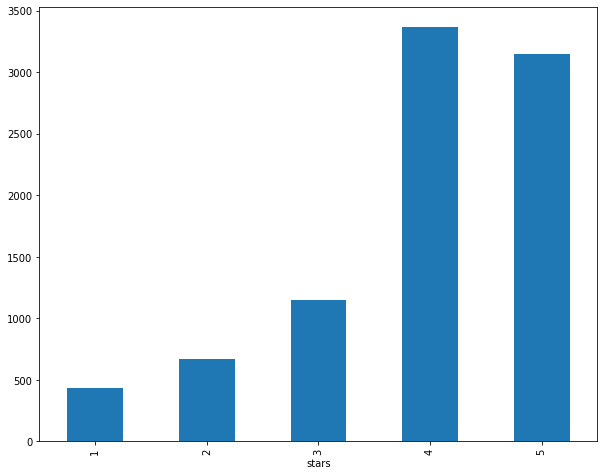

In [6]:
plt.figure(figsize=(10,8))
data.groupby('stars')['cool'].sum().plot.bar()

So, we can see that the number of cool votes assigned to a review GENERALLY increased as users' sentiments shifted from negative to positive. This may also be due to a certain positive bias, but we'll run with the users' honesty.

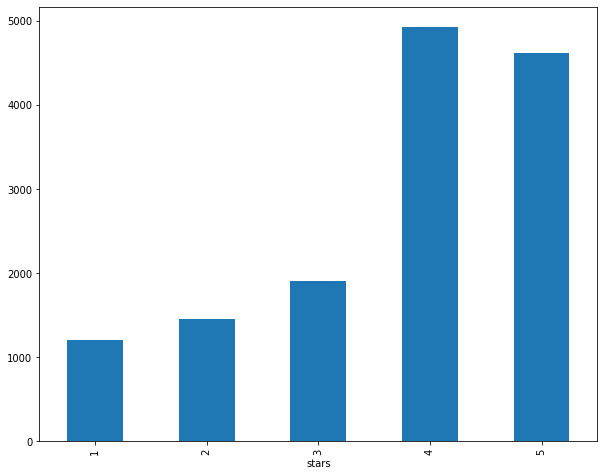

In [7]:
plt.figure(figsize=(10,8))
data.groupby('stars')['useful'].sum().plot.bar()

This follows a similar pattern to that of the 'cool' column, indicating that users agreed very much with people who rated the business highly, leading to a good assumption that the reviews are not fake, but rather trustworthy.

Could we combine the 'cool' and 'useful' features as a single feature, or could we remove one and retain the other, as it reduces redundancy?

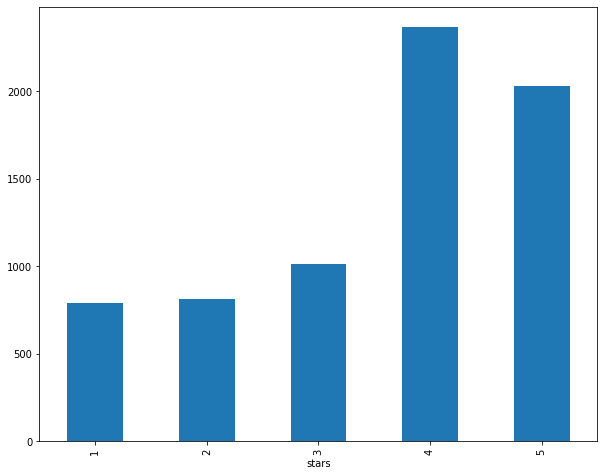

In [8]:
plt.figure(figsize=(10,8))
data.groupby('stars')['funny'].sum().plot.bar()

Again, it follows a similar pattern, so there may be many options in dealing with this variable.

In [9]:
data.groupby('stars')['useful'].mean()

stars
1    1.604806
2    1.563107
3    1.306639
4    1.395916
5    1.381780
Name: useful, dtype: float64

In [10]:
data['stars'].unique()

array([5, 4, 2, 3, 1])

# Feature: Stars

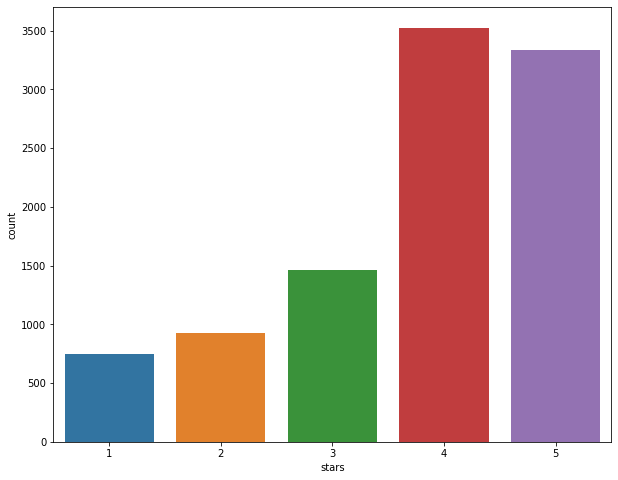

In [11]:
plt.figure(figsize=(10,8))
sns.countplot(data['stars'])

In [12]:
data['year']=data['date'].str.findall('\d{4}').str[0]

In [13]:
data['year'].unique()

array(['2011', '2012', '2010', '2007', '2008', '2009', '2013', '2006',
       '2005'], dtype=object)

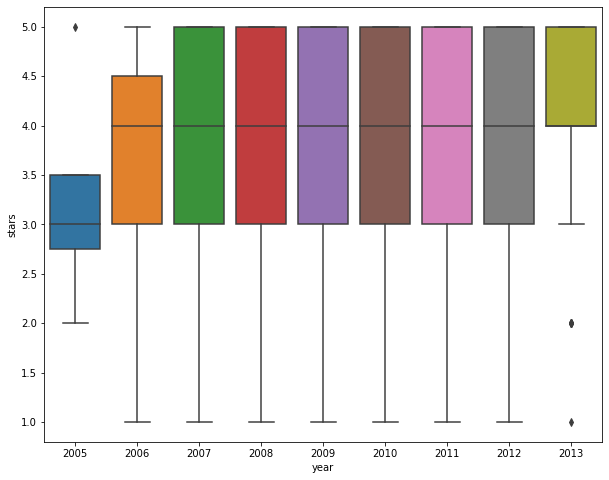

In [14]:
plt.figure(figsize=(10,8))
sns.boxplot(data['year'],data['stars'])

We can see that almost every year, since 2005, has had a similar average rating of 4 stars, while 2013 has 2 outliers in the negative sentiment zone, and reviews in 2005 generally had a mixed sentiment.

In [15]:
data['month']=data['date'].str.findall('\d{2}').str[2]

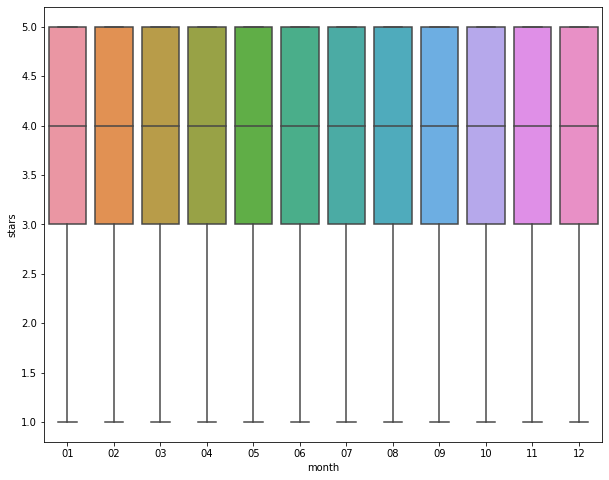

In [16]:
plt.figure(figsize=(10,8))
sns.boxplot(data['month'],data['stars'])

Every month had a similar averate rating.

In [17]:
data['day']=data['date'].str.findall('\d{2}').str[-1]

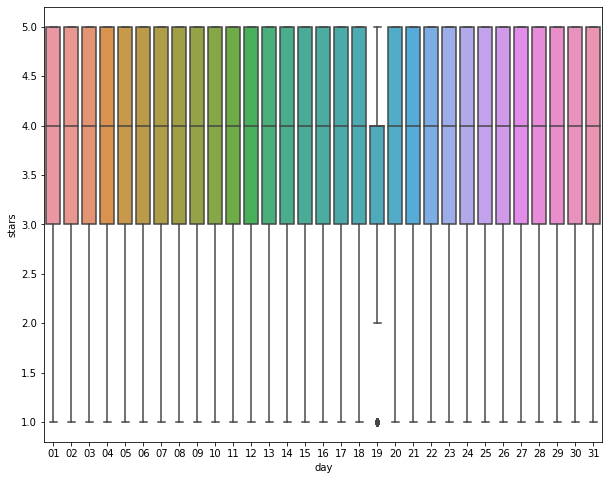

In [18]:
plt.figure(figsize=(10,8))
sns.boxplot(data['day'],data['stars'])

Same pattern follows for the day distribution. So the year, date, month analysis may not have that big an effect as we had hoped for.

Now let us look at the length of reviews and see if they had an effect on the rating.

In [19]:
data['review_length']=data['text'].apply(lambda x:len(x))

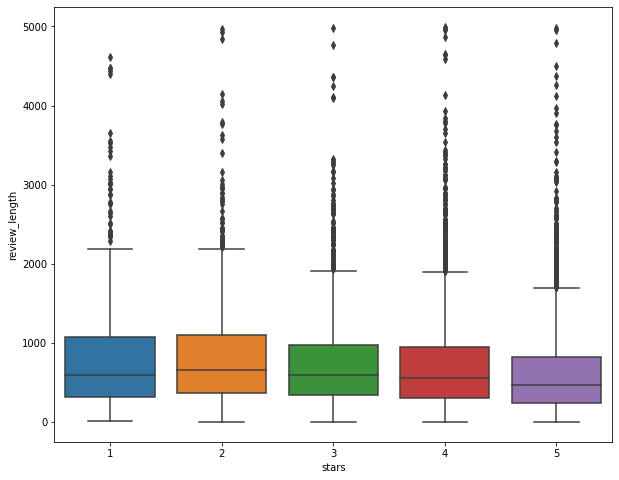

In [20]:
plt.figure(figsize=(10,8))
sns.boxplot(data['stars'],data['review_length'])

The same effect seems to be rippling around, so this new feature may not be needed, but it helps to know that better-reviewed businesses have smaller review lengths, which is understandable.

In [21]:
data.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,year,month,day,review_length
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,2011,01,26,889
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,2011,07,27,1345
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0,2012,06,14,76
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0,2010,05,27,419
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0,2012,01,05,469


In [22]:
var=['cool','useful','funny','review_length']
s=data.groupby('stars')[var].mean()
s

,cool,useful,funny,review_length
stars,,,,
1,0.576769,1.604806,1.056075,826.515354
2,0.719525,1.563107,0.875944,842.256742
3,0.788501,1.306639,0.694730,758.498289
4,0.954623,1.395916,0.670448,712.923142
5,0.944261,1.381780,0.608631,624.999101


In [23]:
s.corr()

,cool,useful,funny,review_length
cool,1.000000,-0.743329,-0.944939,-0.857664
useful,-0.743329,1.000000,0.894506,0.699881
funny,-0.944939,0.894506,1.000000,0.843461
review_length,-0.857664,0.699881,0.843461,1.000000


Cool reviews tend to be less useful, short and more to-the-point. Useful reviews are more funny and have an okay length, and funny reviews are less cool, more useful, and have a higher review length.

In [24]:
len(data[data['stars']==3])/len(data)*100

14.610000000000001

In [25]:
#try deleting neutral reviews
data2=data.loc[data['stars']!=3]

In [26]:
data2.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,year,month,day,review_length
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,2011,01,26,889
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,2011,07,27,1345
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0,2012,06,14,76
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0,2010,05,27,419
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0,2012,01,05,469


In [27]:
data2.stars.unique()

array([5, 4, 2, 1])

1-Positive reviews, 0-negative reviews

In [28]:
data2.loc[(data2['stars']==1)|(data2['stars']==2)]['stars']=0

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [29]:
data2.loc[(data2['stars']==4)|(data2['stars']==5),'stars']=1

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [30]:
data2.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,year,month,day,review_length
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,1,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,2011,01,26,889
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,1,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,2011,07,27,1345
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,1,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0,2012,06,14,76
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,1,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0,2010,05,27,419
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,1,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0,2012,01,05,469


In [31]:
data2=data2.drop(['business_id','date','review_id','type','user_id','year','month','day'],axis=1)

In [32]:
data2.head()

,stars,text,cool,useful,funny,review_length
0,1,My wife took me here on my birthday for breakf...,2,5,0,889
1,1,I have no idea why some people give bad review...,0,0,0,1345
2,1,love the gyro plate. Rice is so good and I als...,0,1,0,76
3,1,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",1,2,0,419
4,1,General Manager Scott Petello is a good egg!!!...,0,0,0,469


In [33]:
X=data2.drop('stars',axis=1)
y=data2['stars']

In [34]:
X.head()

,text,cool,useful,funny,review_length
0,My wife took me here on my birthday for breakf...,2,5,0,889
1,I have no idea why some people give bad review...,0,0,0,1345
2,love the gyro plate. Rice is so good and I als...,0,1,0,76
3,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",1,2,0,419
4,General Manager Scott Petello is a good egg!!!...,0,0,0,469


In [35]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: stars, dtype: int64

In [36]:
d=X['text'][0].lower()

In [37]:
import re

In [38]:
X['text'][0].lower()

'my wife took me here on my birthday for breakfast and it was excellent.  the weather was perfect which made sitting outside overlooking their grounds an absolute pleasure.  our waitress was excellent and our food arrived quickly on the semi-busy saturday morning.  it looked like the place fills up pretty quickly so the earlier you get here the better.\n\ndo yourself a favor and get their bloody mary.  it was phenomenal and simply the best i\'ve ever had.  i\'m pretty sure they only use ingredients from their garden and blend them fresh when you order it.  it was amazing.\n\nwhile everything on the menu looks excellent, i had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious.  it came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete.  it was the best "toast" i\'ve ever had.\n\nanyway, i can\'t wait to go back!'

# Text Mining with NLTK

In [39]:
#text analysis
#do tokenization
#do lowercasing
#remove stopwords
#do stemming/lemmatization
from nltk.stem import WordNetLemmatizer

In [40]:
' '.join(['Hello','Joseph'])

'Hello Joseph'

In [41]:
def process_text(x):
    #tokenization
    x=x.lower()
    tokens=nltk.word_tokenize(x)
    validtokens=[i for i in tokens if i not in set(stopwords.words('english'))]
    lem=WordNetLemmatizer()
    rooted=[lem.lemmatize(i) for i in validtokens]
    return ' '.join(rooted)
    
    

In [42]:
X=X['text'].apply(process_text)

In [43]:
X.head()

0    wife took birthday breakfast excellent . weath...
1    idea people give bad review place . go show , ...
2    love gyro plate . rice good also dig candy sel...
3    rosie , dakota , love chaparral dog park ! ! !...
4    general manager scott petello good egg ! ! ! g...
Name: text, dtype: object

In [44]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer()
X=cv.fit_transform(X)

In [45]:
X.shape

(8539, 24561)

In [46]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1)

# 

In [47]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
model=MultinomialNB()
model.fit(X_train,y_train)
y_preds=model.predict(X_test)
print(confusion_matrix(y_test,y_preds))

[[1471   46]
 [ 175   16]]


In [48]:
from sklearn.metrics import f1_score,accuracy_score
print(accuracy_score(y_test,y_preds))
print(f1_score(y_test,y_preds))

0.8706088992974239
0.9301296237748973


In [52]:
from sklearn.svm import SVC
model2=SVC(kernel='linear')
model2.fit(X_train,y_train)
preds=model2.predict(X_test)
print(f1_score(y_test,preds))
print(accuracy_score(y_test,preds))

0.9326732673267327
0.8805620608899297


In [57]:
from sklearn.model_selection import cross_val_score
c=[0.001,0.01,0.1,1,10,100]
for i in c:
    m=SVC(kernel='linear',C=i)
    m.fit(X_train,y_train)
    print(accuracy_score(y_test,m.predict(X_test)))

    


    


0.8881733021077284
0.892271662763466
0.8870023419203747
0.8805620608899297
0.8729508196721312
0.867096018735363


So, the optimal C value is 0.01 if we proceed further with the SVM model, and that gives us an accuracy of 89.22%, which is pretty acceptable.